In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense
from sklearn.utils.class_weight import compute_class_weight

# Read data
Data = pd.read_excel(r"/content/drive/MyDrive/Thesis/Product Review Sentiment Analysis.xlsx")

# Define Bangla stopwords
bangla_stopwords = [
    'এই', 'সে', 'এ', 'তার', 'যে', 'আমাদের', 'তাদের', 'আমরা', 'তোমরা',
    'তুমি', 'তারা', 'যার', 'কোন', 'কিছু', 'এক', 'অনেক', 'অধিক', 'সব',
    'কত', 'কোথায়'
]

# Preprocessing function
def preprocess_text(text):
    text = re.sub('<[^<]+?>', '', text)  # Remove HTML tags
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    text = ' '.join([word for word in text.split() if len(word) > 1])  # Remove single characters
    text = re.sub(r'\s+', ' ', text)  # Remove multiple spaces
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.strip()  # Remove leading and trailing spaces
    return text

# Apply preprocessing to the 'Reviews' column
Data['Reviews'] = Data['Reviews'].apply(lambda x: preprocess_text(x) if pd.notnull(x) else x)

# Download NLTK data (you only need to do this once)
nltk.download('punkt')

# Tokenization function
def tokenize_text(text):
    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)
    tokens = word_tokenize(text)
    return tokens

# Remove stopwords
def remove_stopwords(text):
    words = word_tokenize(text)
    filtered_words = [word for word in words if word.lower() not in bangla_stopwords]
    filtered_text = ' '.join(filtered_words)
    return filtered_text

# Apply stopword removal
Data['Cleaned_Reviews'] = Data['Reviews'].apply(remove_stopwords)

# Apply tokenization
Data['Tokenized_Reviews'] = Data['Reviews'].apply(lambda x: tokenize_text(x) if pd.notnull(x) else x)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
# Drop NaN values
Data = Data.dropna(subset=['Tokenized_Reviews'])

# Convert text to sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(Data['Cleaned_Reviews'])
X = tokenizer.texts_to_sequences(Data['Cleaned_Reviews'])
X = pad_sequences(X, padding='post')

# Encoding sentiments
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(Data['Sentiments'])  # Use label encoder instead of one-hot encoding




In [ ]:
import os
# Download and unzip the embeddings file
if not os.path.exists('wiki-news-300d-1M.vec'):
    !wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip


--2024-05-19 20:38:19--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.162.163.34, 3.162.163.19, 3.162.163.11, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.162.163.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M  54.6MB/s    in 13s     

2024-05-19 20:38:33 (51.6 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]



In [ ]:
!unzip wiki-news-300d-1M.vec.zip

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [ ]:
# Load pre-trained word embeddings
embeddings_index = {}
with open('wiki-news-300d-1M.vec', encoding='utf-8') as f:
    for line in f:
        word, vec = line.split(' ', 1)
        vec = np.array(vec.split(' '), dtype=np.float32) # Use numpy.array instead of array
        embeddings_index[word] = vec

# Define embedding dimension and maximum vocabulary size
embedding_dim = 300
max_features = len(tokenizer.word_index) + 1

# Create embedding matrix
embedding_matrix = np.zeros((max_features, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i >= max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
print(y_train.shape)

(2857,)


In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1]))

In [ ]:
!pip install catboost


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 10.6 MB/s eta 0:00:00


In [ ]:
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
import torch
from catboost import CatBoostClassifier

catboost_model = CatBoostClassifier(
    iterations=1000,  # Number of trees
    learning_rate=0.1,  # Learning rate
    depth=6,  # Depth of trees
    loss_function='MultiClass',  # Multiclass classification
    task_type='GPU' if torch.cuda.is_available() else 'CPU'  # Use GPU if available
)


In [ ]:
catboost_model.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=100,
    early_stopping_rounds=50,

)
train_accuracy = catboost_model.score(X_train, y_train)
test_accuracy = catboost_model.score(X_test, y_test)
print("Train Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

0:	learn: 0.6431219	test: 0.6440839	best: 0.6440839 (0)	total: 272ms	remaining: 4m 32s
100:	learn: 0.1612453	test: 0.1856745	best: 0.1856745 (100)	total: 3.63s	remaining: 32.3s
200:	learn: 0.0970855	test: 0.1242192	best: 0.1242192 (200)	total: 9.06s	remaining: 36s
300:	learn: 0.0649473	test: 0.0926129	best: 0.0926129 (300)	total: 14.3s	remaining: 33.1s
400:	learn: 0.0475902	test: 0.0756720	best: 0.0756720 (400)	total: 16.2s	remaining: 24.1s
500:	learn: 0.0361225	test: 0.0637429	best: 0.0637429 (500)	total: 18s	remaining: 17.9s
600:	learn: 0.0291740	test: 0.0568441	best: 0.0568441 (600)	total: 20s	remaining: 13.3s
700:	learn: 0.0237046	test: 0.0510502	best: 0.0510388 (698)	total: 21.7s	remaining: 9.27s
800:	learn: 0.0198715	test: 0.0470876	best: 0.0470876 (800)	total: 23.4s	remaining: 5.8s
900:	learn: 0.0168634	test: 0.0437071	best: 0.0436576 (899)	total: 27.4s	remaining: 3.01s
999:	learn: 0.0146145	test: 0.0410986	best: 0.0410905 (996)	total: 33.3s	remaining: 0us
bestTest = 0.041090459

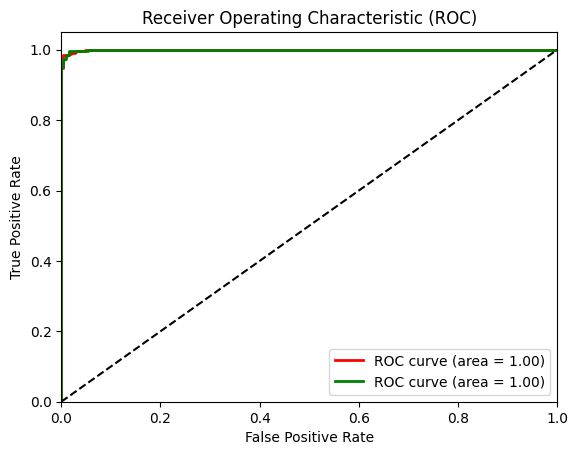

In [ ]:
# prompt: roc curve for this

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Get predicted probabilities for each class
y_pred_prob = catboost_model.predict_proba(X_test)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
lw = 2
colors = ['red', 'green', 'blue']
for i, color in zip(range(len(np.unique(y_test))), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve (area = %0.2f)' % roc_auc[i])

plt.plot([0, 1], [0, 1], color='black', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# prompt: generate confusion matrix and classification report for this

from sklearn.metrics import confusion_matrix, classification_report

# Generate confusion matrix
cm = confusion_matrix(y_test, catboost_model.predict(X_test))

# Print confusion matrix
print("Confusion Matrix:")
print(cm)

# Generate classification report
cr = classification_report(y_test, catboost_model.predict(X_test))

# Print classification report
print("Classification Report:")
print(cr)


Confusion Matrix:
[[336   4]
 [  6 369]]
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       340
           1       0.99      0.98      0.99       375

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715

